## **Predicción de Precios de Vehículos Usados (Core)**
### **Requisitos:**

**1. Carga y Exploración de Datos:**

- Descargar y cargar el dataset.

- Realizar una exploración inicial para entender la estructura del dataset.

- Identificar valores faltantes, duplicados y outliers.

**2. Limpieza y Preprocesamiento:**

- Manejar valores faltantes.

- Eliminar duplicados.

- Corregir inconsistencias en los datos categóricos.

- Escalar las características numéricas.

- Realizar transformaciones necesarias para las características categóricas.

**3. Exploración de Datos:**

- Crear visualizaciones univariadas y multivariadas.

- Calcular estadísticas descriptivas.

**4. Modelado y Evaluación:**

- Implementar al menos dos modelos de regresión (Linear Regression y Random Forest Regressor).

- Evaluar los modelos utilizando MSE, RMSE, y R^2.

- Seleccionar el mejor modelo basado en las métricas de evaluación.

**5. Optimización del Modelo:**

- Optimizar el modelo seleccionado utilizando GridSearchCV.

**6. Documentación y Entrega:**

- Documentar todo el proceso en un archivo .ipynb claramente comentado.

- Crear visualizaciones con interpretaciones.

- Subir el archivo a un repositorio en GitHub con un tag de liberación.


In [10]:
# --- 1. Carga y Exploración de Datos ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Cargar el dataset
file_path = r'C:\Users\Andy\Documents\CodingDojo\Módulo_2_ML\Tareas_ML\Data_Tareas_ML\used-cars-data.csv'
data = pd.read_csv(file_path)
data.drop(['id','url','region','region_url','cylinders','VIN','drive','size','paint_color','image_url','description','county','state','lat','long','posting_date'], axis=1, inplace=True)
# Inspección inicial
print(f"Tamaño original del dataset: {data.shape}")

# Reducir el tamaño del dataset (muestreo estratificado)
sample_fraction = 0.2  # Ajusta según el tamaño deseado
if 'price' in data.columns:
    data['price_category'] = pd.qcut(data['price'], q=10, duplicates='drop')
    data_sampled = data.groupby('price_category', group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=42))
    data_sampled = data_sampled.drop(columns=['price_category'])  # Eliminar la categoría temporal
    print(f"Tamaño del dataset después del muestreo estratificado: {data_sampled.shape}")

# Comprobar el dataset reducido
print(data_sampled.head())
print(data_sampled.info())

# Identificar valores faltantes y duplicados
print("\nValores faltantes por columna:")
print(data_sampled.isnull().sum())
print("\nNúmero de filas duplicadas:")
print(data_sampled.duplicated().sum())

# --- 2. Limpieza y Preprocesamiento ---

# Manejar valores faltantes por tipo de dato
numerical_columns = data_sampled.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data_sampled.select_dtypes(include=['object']).columns

# Imputar valores faltantes en columnas numéricas con la mediana
data_sampled[numerical_columns] = data_sampled[numerical_columns].fillna(data_sampled[numerical_columns].median())

# Imputar valores faltantes en columnas categóricas con un valor por defecto
data_sampled[categorical_columns] = data_sampled[categorical_columns].fillna('missing')

# Eliminar duplicados
data_sampled.drop_duplicates(inplace=True)

# Corregir inconsistencias en datos categóricos
categorical_columns = data_sampled.select_dtypes(include=['object', 'category']).columns
if not categorical_columns.empty:
    for col in categorical_columns:
        # Convertir a string y manejar valores nulos
        data_sampled[col] = data_sampled[col].astype(str).fillna('missing')
        data_sampled[col] = data_sampled[col].str.strip().str.lower()

# Dataset final listo para el modelado
print("\n--- Dataset Preprocesado ---")
print(data_sampled.head())

Tamaño original del dataset: (426880, 10)
Tamaño del dataset después del muestreo estratificado: (85375, 10)
        price    year manufacturer           model  condition    fuel  \
326708      0 2015.00    chevrolet  silverado 2500        NaN  diesel   
394330      0 2015.00         ford           f-150        NaN     gas   
295692    300 2010.00          NaN             all        NaN     gas   
396499      0 2020.00          NaN             All        NaN     gas   
114706      1 2015.00          bmw        6 series  excellent     gas   

        odometer title_status transmission   type  
326708  95078.00        clean    automatic  truck  
394330  86221.00        clean    automatic  truck  
295692 100000.00        clean    automatic    NaN  
396499  10000.00        clean    automatic    NaN  
114706  48826.00        clean    automatic  sedan  
<class 'pandas.core.frame.DataFrame'>
Index: 85375 entries, 326708 to 344959
Data columns (total 10 columns):
 #   Column        Non-Null Co

In [11]:
# --- Transformar características categóricas ---
from sklearn.preprocessing import LabelEncoder

# Identificar columnas categóricas
categorical_columns = data_sampled.select_dtypes(include=['object', 'category']).columns.tolist()

# Corregir inconsistencias en datos categóricos
if categorical_columns:  # Verifica si la lista no está vacía
    for col in categorical_columns:
        # Convertir a string y manejar valores nulos
        data_sampled[col] = data_sampled[col].astype(str).fillna('missing')
        data_sampled[col] = data_sampled[col].str.strip().str.lower()

# One-Hot Encoding para columnas con pocas categorías
categorical_columns_limited = [col for col in categorical_columns if data_sampled[col].nunique() < 50]
data_sampled = pd.get_dummies(data_sampled, columns=categorical_columns_limited, drop_first=True)

# Label Encoding para columnas con muchas categorías
for col in categorical_columns:
    if col not in categorical_columns_limited:  # Columnas no incluidas en One-Hot Encoding
        le = LabelEncoder()
        data_sampled[col] = le.fit_transform(data_sampled[col])

# Dividir en variables predictoras (X) y objetivo (Y)
X = data_sampled.drop('price', axis=1)
y = data_sampled['price']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verificar las dimensiones de los conjuntos
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

Dimensiones de X_train: (46313, 77)
Dimensiones de X_test: (19849, 77)
Dimensiones de y_train: (46313,)
Dimensiones de y_test: (19849,)


In [12]:
print("\nPrimeras filas de X_train:")
print(X_train.head())
print("\nPrimeras filas de y_train:")
print(y_train.head())


Primeras filas de X_train:
          year  model  odometer  manufacturer_alfa-romeo  \
137571 2020.00   2849    303.00                    False   
357251 2013.00   3679  16283.00                    False   
23912  2009.00   1188  85966.00                    False   
237197 2013.00   4377  93498.00                    False   
207980 2008.00   7754  95260.00                    False   

        manufacturer_aston-martin  manufacturer_audi  manufacturer_bmw  \
137571                      False              False             False   
357251                      False              False             False   
23912                       False              False              True   
237197                      False              False             False   
207980                      False              False             False   

        manufacturer_buick  manufacturer_cadillac  manufacturer_chevrolet  \
137571               False                  False                   False   
357251      


--- Estadísticas Descriptivas ---
             price     year    model    odometer
count     66162.00 66162.00 66162.00    66162.00
mean      17799.52  2010.37  6252.97   105916.66
std      482652.50     9.90  3374.36   216861.58
min           0.00  1900.00     0.00        0.00
25%        5000.00  2007.00  3426.00    47487.50
50%       11500.00  2013.00  6132.00    94143.00
75%       22499.75  2016.00  9315.75   140000.00
max   123456789.00  2022.00 12150.00 10000000.00

--- Visualización Univariada: Histogramas ---


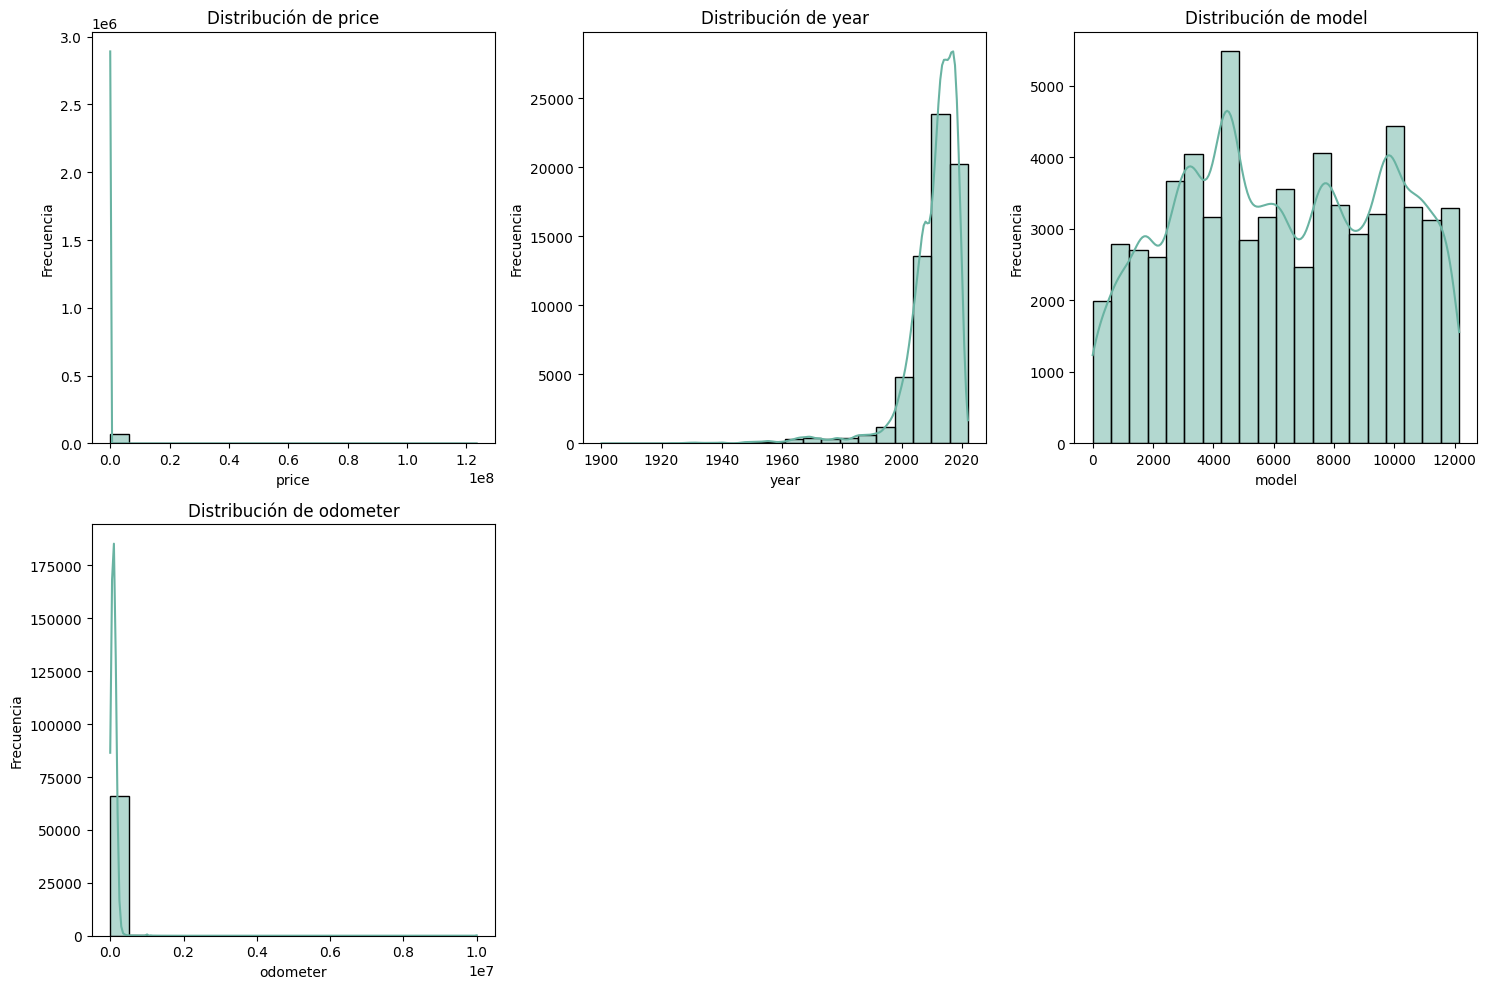


--- Visualización Multivariada: Mapa de Calor ---


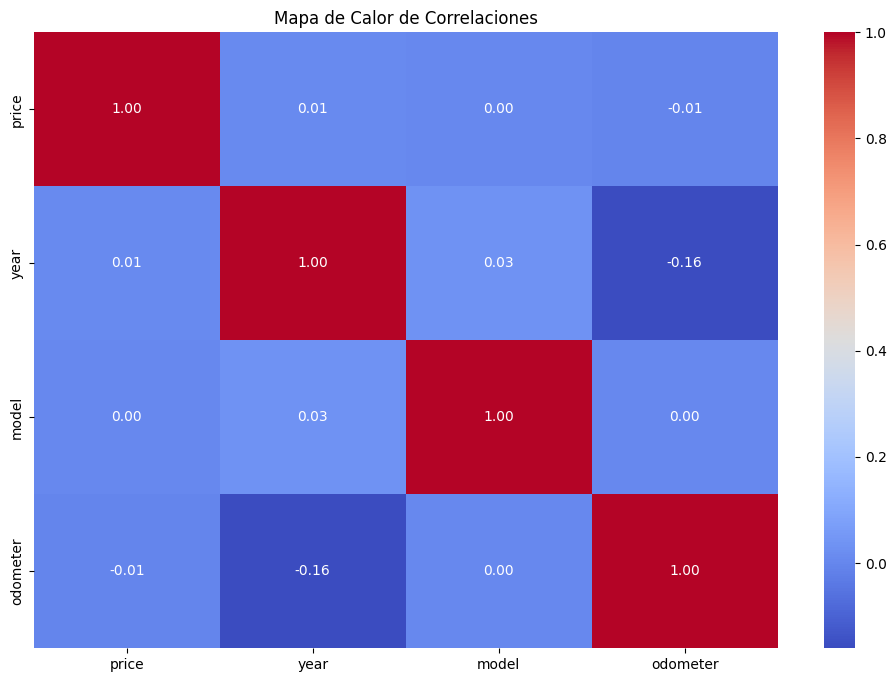

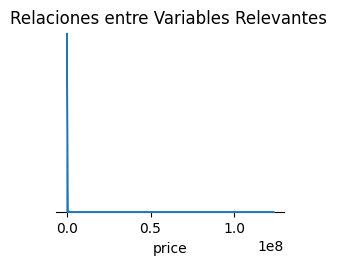


--- Detección de Outliers: Boxplots ---


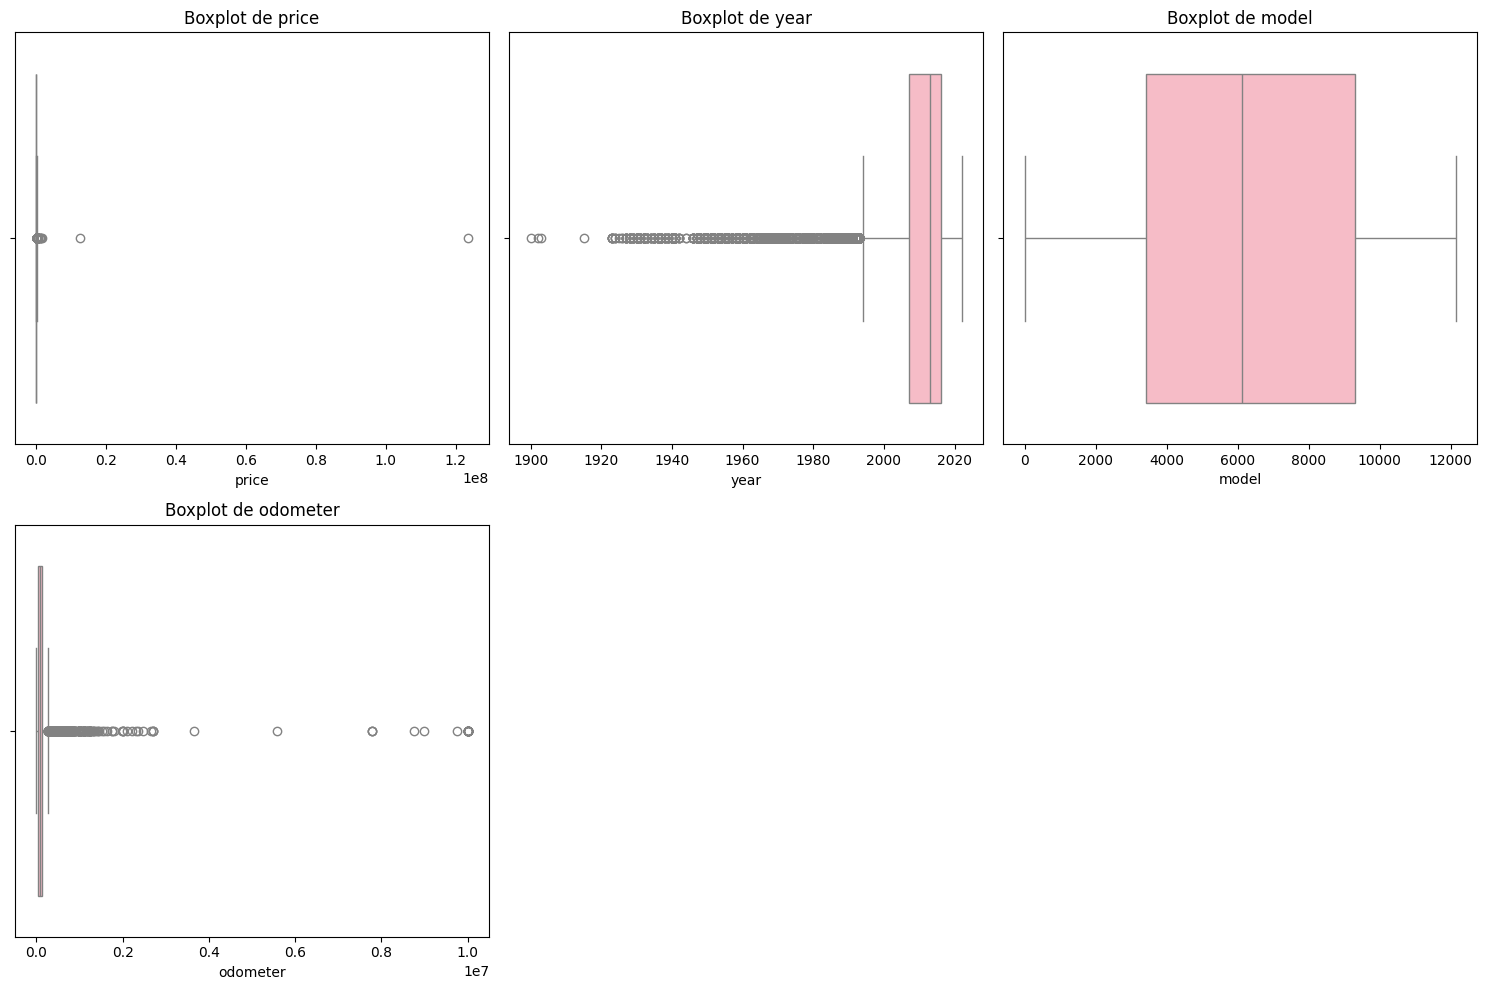

In [16]:
# --- Exploratory Data Analysis (EDA) ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Estadísticas Descriptivas ---
print("\n--- Estadísticas Descriptivas ---")
print(data_sampled.describe())

# --- 2. Visualización Univariada ---
# Histograma para las variables numéricas
numerical_columns = data_sampled.select_dtypes(include=['float64', 'int64']).columns
print("\n--- Visualización Univariada: Histogramas ---")

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot((len(numerical_columns) + 2) // 3, 3, i)
    sns.histplot(data_sampled[col], kde=True, bins=20, color='#69b3a2', edgecolor='black')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Visualización de variables categóricas con conteos
categorical_columns = data_sampled.select_dtypes(include=['object', 'category']).columns
if len(categorical_columns) > 0:
    print("\n--- Visualización Univariada: Variables Categóricas ---")
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=data_sampled, y=col, palette='coolwarm', order=data_sampled[col].value_counts().index)
        plt.title(f'Conteo de {col}')
        plt.ylabel(col)
        plt.xlabel('Frecuencia')
        plt.show()

# --- 3. Visualización Multivariada ---
# Mapa de calor de correlación para variables numéricas
print("\n--- Visualización Multivariada: Mapa de Calor ---")
correlation_matrix = data_sampled[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Mapa de Calor de Correlaciones")
plt.show()

# Selección de variables con alta correlación con la variable objetivo
if 'price' in correlation_matrix.columns:
    high_corr_columns = correlation_matrix['price'][abs(correlation_matrix['price']) > 0.3].index.tolist()
    sns.pairplot(data_sampled[high_corr_columns], diag_kind='kde', corner=True, palette='coolwarm')
    plt.suptitle("Relaciones entre Variables Relevantes", y=1.02)
    plt.show()

# --- 4. Identificación de Outliers ---
# Boxplots para detectar posibles valores atípicos en variables numéricas
print("\n--- Detección de Outliers: Boxplots ---")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot((len(numerical_columns) + 2) // 3, 3, i)
    sns.boxplot(data=data_sampled, x=col, color='#ffb3c1')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [ ]:
# Implementar los dos modelos seleccionados: Linear Regression y Random Forest Regressor
models_to_evaluate = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42)
}

print("\n--- Evaluación de Modelos Manual ---")
model_results = {}
for name, model in models_to_evaluate.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Métricas de evaluación
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Almacenar resultados
    model_results[name] = {'MSE': mse, 'RMSE': rmse, 'R^2': r2}
    
    # Mostrar resultados
    print(f"\n{name} Performance:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2: {r2:.2f}")

# Seleccionar el mejor modelo basado en R^2
best_model_name = max(model_results, key=lambda x: model_results[x]['R^2'])
best_model = models_to_evaluate[best_model_name]
print(f"\n--- Mejor Modelo Seleccionado: {best_model_name} ---")

# --- 5. Optimización del Modelo ---
if best_model_name == "Random Forest Regressor":  # Optimizar solo si es Random Forest
    print("\n--- Optimizando Random Forest con GridSearch ---")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring='r2', verbose=2)
    grid_search.fit(X_train, y_train)

    print("\n--- Mejor Modelo Después de GridSearch ---")
    print(grid_search.best_params_)
    final_model = grid_search.best_estimator_
else:
    # Si no es Random Forest, usar directamente el modelo seleccionado
    final_model = best_model

# Evaluar el modelo optimizado
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, final_predictions)

'''
Los resultados obtenidos muestran un bajo rendimiento en los 
modelos de predicción de precios de autos, con valores negativos 
de R² que indican una incapacidad para explicar la variabilidad de los datos.

Esto podría deberse a problemas en la calidad del dataset, como ruido, 
outliers, y variables irrelevantes, además de una falta de optimización de hiperparámetros. 

Para mejorar, es crucial realizar una selección y transformación de características 
más exhaustiva, tratar outliers y explorar modelos más robustos como XGBoost o LightGBM. 

Además, ajustar los hiperparámetros y aumentar el tamaño del dataset podrían ayudar a 
obtener mejores resultados.
'''



--- Evaluación de Modelos Manual ---

Linear Regression Performance:
MSE: 639350909.21
RMSE: 25285.39
R^2: -0.84

Random Forest Regressor Performance:
MSE: 10668791073.60
RMSE: 103289.84
R^2: -29.69

--- Mejor Modelo Seleccionado: Linear Regression ---
